# Eletiva NLP - APS 02
## Vector-Based Search
### Aluno: Raphael Lahiry

## Step 01

In [1]:
import torch
import pandas as pd
from transformers import BertTokenizer, BertModel

# Load TripAdvisor Restaurant Reviews dataset
df = pd.read_csv('trip_advisor_restaurants_sp.csv')
df.rename(columns={'Name': 'restaurant', 'Description': 'review'}, inplace=True)

# Load pre-trained sBERT model
tokenizer = BertTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model = BertModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

# Generate initial embeddings for restaurant reviews
inputs = tokenizer(df['review'].tolist(), return_tensors="pt", truncation=True, padding=True)

# Generate embeddings with the model
outputs = model(**inputs)

# Take the mean of the last hidden states and detach from the computation graph
initial_embeddings = outputs.last_hidden_state.mean(dim=1).detach()


c:\Users\rapha\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch.nn as nn
import torch.optim as optim

# Define the auto-encoder
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoded_dim=128):
        super(AutoEncoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, encoded_dim)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoded_dim, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Instantiate the model
input_dim = initial_embeddings.shape[1]
autoencoder = AutoEncoder(input_dim=input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)


In [3]:
# Auto-Encoder Training loop
num_epochs = 20
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = autoencoder(initial_embeddings)
    loss = criterion(outputs, initial_embeddings)
    loss.backward()
    optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [1/20], Loss: 0.0157
Epoch [2/20], Loss: 0.0136
Epoch [3/20], Loss: 0.0116
Epoch [4/20], Loss: 0.0095
Epoch [5/20], Loss: 0.0074
Epoch [6/20], Loss: 0.0058
Epoch [7/20], Loss: 0.0053
Epoch [8/20], Loss: 0.0045
Epoch [9/20], Loss: 0.0035
Epoch [10/20], Loss: 0.0029
Epoch [11/20], Loss: 0.0028
Epoch [12/20], Loss: 0.0028
Epoch [13/20], Loss: 0.0028
Epoch [14/20], Loss: 0.0028
Epoch [15/20], Loss: 0.0027
Epoch [16/20], Loss: 0.0027
Epoch [17/20], Loss: 0.0027
Epoch [18/20], Loss: 0.0026
Epoch [19/20], Loss: 0.0025
Epoch [20/20], Loss: 0.0024


In [4]:
# Extract tuned embeddings
with torch.no_grad():
    embeddings_tuned = autoencoder.encoder(initial_embeddings).cpu().numpy()


## Step 02

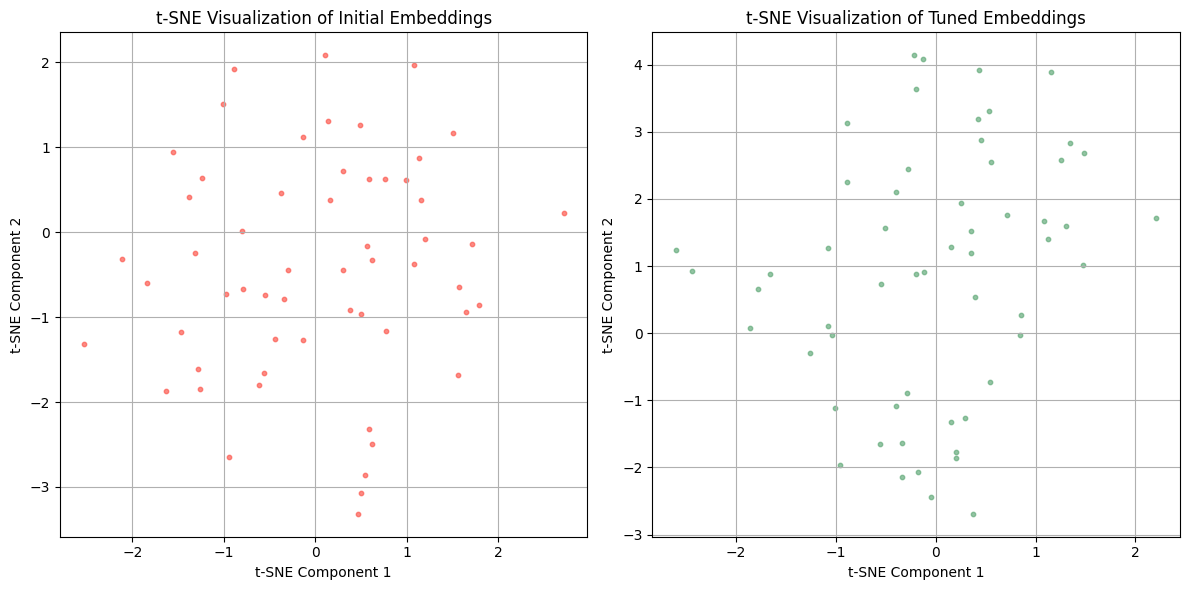

In [5]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Applying t-SNE to reduce embeddings to 2D for visualization
# For initial embeddings
tsne_initial = TSNE(n_components=2, random_state=42)
embeddings_2d_initial = tsne_initial.fit_transform(initial_embeddings.cpu().numpy())

# For tuned embeddings
tsne_tuned = TSNE(n_components=2, random_state=42)
embeddings_2d_tuned = tsne_tuned.fit_transform(embeddings_tuned)

# Plotting the t-SNE visualization
plt.figure(figsize=(12, 6))

# Plot initial embeddings
plt.subplot(1, 2, 1)
plt.scatter(embeddings_2d_initial[:, 0], embeddings_2d_initial[:, 1], alpha=0.7, s=10, color='xkcd:coral')
plt.title('t-SNE Visualization of Initial Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid()


# Plot tuned embeddings
plt.subplot(1, 2, 2)
plt.scatter(embeddings_2d_tuned[:, 0], embeddings_2d_tuned[:, 1], alpha=0.7, s=10, color='xkcd:tea')
plt.title('t-SNE Visualization of Tuned Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid()

plt.tight_layout()
plt.show()

## Step 03

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Function to find restaurants based on their reviews
def find_seatch_restaurants(query):

    inputs = tokenizer(query, return_tensors="pt", truncation=True, padding=True)

    outputs = model(**inputs)

    query_embedding = outputs.last_hidden_state.mean(dim=1).detach()

    query_embedding_tuned = autoencoder.encoder(query_embedding).detach()

    # Calculate cosine similarity
    similarities = cosine_similarity(query_embedding_tuned, embeddings_tuned).flatten()

    # Get indices of the most similar restaurants
    most_similar_indices = [idx for idx in similarities.argsort()[::-1] if similarities[idx] >= 0.7]

    # Return restaurant names and their similarities
    return [(df['restaurant'][idx], similarities[idx]) for idx in most_similar_indices[:10]]

query_1 = "sushi"
results_1 = find_seatch_restaurants(query_1)

print("Test 1 Results (10 results for 'sushi'):")
for i, (name, similarity) in enumerate(results_1):
    print(f"{i + 1}. {name} - Similarity: {similarity:.4f}")

query_2 = "hambúrguer"
results_2 = find_seatch_restaurants(query_2)

print("\nTest 2 Results (less than 10 results for 'hambúrguer'):")
for i, (name, similarity) in enumerate(results_2):
    print(f"{i + 1}. {name} - Similarity: {similarity:.4f}")

query_3 = "maravilhoso"
results_3 = find_seatch_restaurants(query_3)

print("\nTest 3 Results (non-obvious results for 'maravilhoso'):")
for i, (name, similarity) in enumerate(results_3):
    print(f"{i + 1}. {name} - Similarity: {similarity:.4f}")


Test 1 Results (10 results for 'sushi'):
1. A Casa do Porco - Similarity: 0.8457
2. Noah Gastronomia Paulista - Similarity: 0.8455
3. Baggio Pizzaria & Focacceria Moema - Similarity: 0.8446
4. Pizzaria Veridiana Jardins - Similarity: 0.8428
5. Bráz Quintal - Similarity: 0.8427
6. Myk Restaurante - Similarity: 0.8425
7. Djapa - Similarity: 0.8409
8. La Braciera Pizza Napoletana - Similarity: 0.8393
9. Parrillada Fuego Celeste - Similarity: 0.8376
10. Dona Firmina Pizzaria - Similarity: 0.8375

Test 2 Results (less than 10 results for 'hambúrguer'):
1. Baggio Pizzaria & Focacceria Moema - Similarity: 0.7239
2. La Braciera Pizza Napoletana - Similarity: 0.7225
3. I Love Burger - Similarity: 0.7213
4. Vicolo Nostro - Similarity: 0.7183
5. Djapa - Similarity: 0.7182
6. A Casa do Porco - Similarity: 0.7180
7. Myk Restaurante - Similarity: 0.7179
8. Famiglia Mancini - Similarity: 0.7175
9. Noah Gastronomia Paulista - Similarity: 0.7167
10. Modern Mamma Osteria - Similarity: 0.7165

Test 3 Res